# ***Predict A Doctor's Consultation Fee*** 

##### IMPORTING NECESSARY LIBRARIES

In [280]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

##### LOADING THE DATASET

In [281]:
df_train = pd.read_csv('Final_Train.csv')
df_test = pd.read_csv('Final_Test.csv')
df_train.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
0,"BHMS, MD - Homeopathy",24 years experience,100%,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100
1,"BAMS, MD - Ayurveda Medicine",12 years experience,98%,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350
2,"MBBS, MS - Otorhinolaryngology",9 years experience,NaN,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300
3,"BSc - Zoology, BAMS",12 years experience,NaN,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore ?250 Available on...",250
4,BAMS,20 years experience,100%,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250


In [282]:
df_test.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info
0,MBBS,35 years experience,NaN,"Ghatkopar East, Mumbai",General Medicine,NaN
1,"MBBS, Diploma in Otorhinolaryngology (DLO)",31 years experience,NaN,"West Marredpally, Hyderabad",ENT Specialist,NaN
2,"MBBS, DDVL",40 years experience,70%,"KK Nagar, Chennai",Dermatologists,"70% 4 Feedback KK Nagar, Chennai"
3,BAMS,0 years experience,NaN,"New Ashok Nagar, Delhi",Ayurveda,NaN
4,"BDS, MDS - Conservative Dentistry & Endodontics",16 years experience,100%,"Kanakpura Road, Bangalore",Dentist,General Dentistry Conservative Dentistry Cosme...


#### EDA 

In [283]:
# check for the shape of dataset
df_train.shape

(5961, 7)

In [284]:
df_test.shape

(1987, 6)

###### ''' As per above details '''
* Train - we have 5961 rows and 7 columns
* Test - we have 1987 rows and 6 columns

In [285]:
# check for the datatypes
df_train.dtypes

Qualification         object
Experience            object
Rating                object
Place                 object
Profile               object
Miscellaneous_Info    object
Fees                   int64
dtype: object

In [286]:
df_test.dtypes

Qualification         object
Experience            object
Rating                object
Place                 object
Profile               object
Miscellaneous_Info    object
dtype: object

###### ''' As per above details '''
* Train - we have all objects and one integer column
* Test - we have all objects datatypes

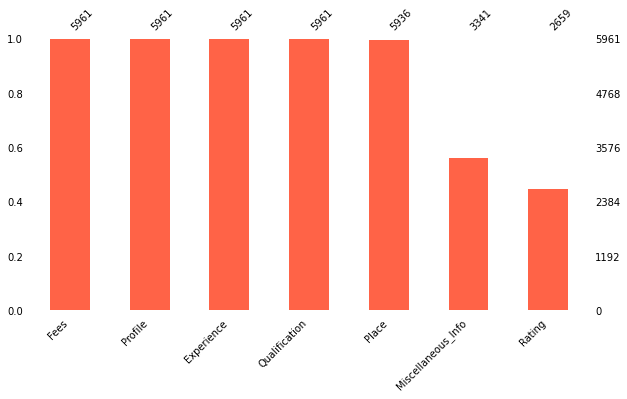

In [287]:
# Let's check for the missing values in both the datasets.
msno.bar(df_train,color='tomato',figsize=(10,5),fontsize=10,sort='descending')
plt.show()

In [288]:
df_train.isnull().sum().sort_values(ascending=False)

Rating                3302
Miscellaneous_Info    2620
Place                   25
Qualification            0
Experience               0
Profile                  0
Fees                     0
dtype: int64

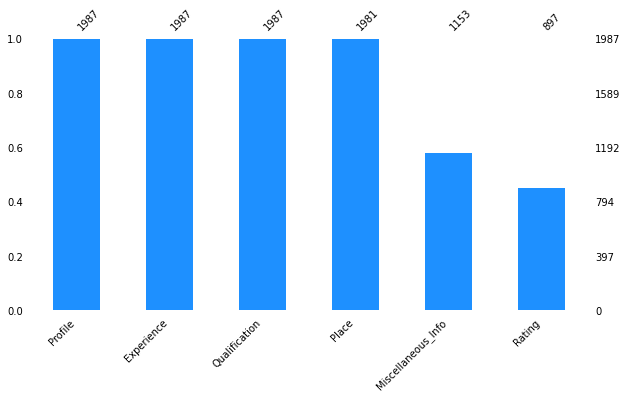

In [289]:
msno.bar(df_test,color='dodgerblue',figsize=(10,5),fontsize=10,sort='descending')
plt.show()

In [290]:
df_test.isnull().sum().sort_values(ascending=False)

Rating                1090
Miscellaneous_Info     834
Place                    6
Qualification            0
Experience               0
Profile                  0
dtype: int64

##### ''' As per above details '''
* Train - we have missing values in Rating, Miscellaneous_Info, Place columns
* Test - we have missing values in Rating, Miscellaneous_Info, Place columns

Let's start from the simplest taks i.e. Experience columns which needs to be seperated string values

In [291]:
# Train set
df_train['Experience'] = df_train['Experience'].str.split()
df_train['Experience'] = df_train['Experience'].str[0].astype('int')

In [292]:
# Test set
df_test['Experience'] = df_test['Experience'].str.split()
df_test['Experience'] = df_test['Experience'].str[0].astype('int')

In [293]:
''' Now let's handle the Place variable by seperating the city and place '''
# first fill all the missing values as Uknown.
df_train['Place'].fillna("Unknown,Unknown",inplace=True)
# Now split the place and City values
df_train['Place'] = df_train['Place'].str.split(",")
df_train['City'] = df_train['Place'].str[-1]
df_train['Place'] = df_train['Place'].str[0]

In [294]:
''' Now let's handle the Place variable by seperating the city and place '''
# first fill all the missing values as Uknown.
df_test['Place'].fillna("Unknown,Unknown",inplace=True)
# Now split the place and City values
df_test['Place'] = df_test['Place'].str.split(",")
df_test['City'] = df_test['Place'].str[-1]
df_test['Place'] = df_test['Place'].str[0]

''' Now we are moving to clean rest of the features '''

In [295]:
# first let clean the Ratings columns as its not in standard format
df_train['Rating'].fillna("-99%",inplace=True)

In [296]:
df_train['Rating'] = df_train['Rating'].str[:-1].astype('int')

In [297]:
bins = [-99,0,10,20,30,40,50,60,70,80,90,100]
labels = [i for i in range(11)]
df_train['Rating'] = pd.cut(df_train['Rating'],bins=bins,labels=labels,include_lowest=True)

In [298]:
# first let clean the Ratings columns as its not in standard format
df_test['Rating'].fillna("-99%",inplace=True)
df_test['Rating'] = df_test['Rating'].str[:-1].astype('int')

In [299]:
bins = [-99,0,10,20,30,40,50,60,70,80,90,100]
labels = [i for i in range(11)]
df_test['Rating'] = pd.cut(df_test['Rating'],bins=bins,labels=labels,include_lowest=True)

''' Here I have tried to replace the mean value to rating column, but the output was not logically correct. So, its better group it in order to analyse the data accurately'
* Have grouped them into bins of size10. Missing values will be 0, 0-9% will be 1, 10-19% will be class2 and so on''

##### Feature Engineering for Qualification attribute

In [300]:
df_train.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,City
0,"BHMS, MD - Homeopathy",24,10,Kakkanad,Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,Ernakulam
1,"BAMS, MD - Ayurveda Medicine",12,10,Whitefield,Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,Bangalore
2,"MBBS, MS - Otorhinolaryngology",9,0,Mathikere - BEL,ENT Specialist,NaN,300,Bangalore
3,"BSc - Zoology, BAMS",12,0,Bannerghatta Road,Ayurveda,"Bannerghatta Road, Bangalore ?250 Available on...",250,Bangalore
4,BAMS,20,10,Keelkattalai,Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,Chennai


In [301]:
df_train['City'].value_counts()

 Bangalore             1258
 Mumbai                1219
 Delhi                 1185
 Hyderabad              951
 Chennai                855
 Coimbatore             228
 Ernakulam              153
 Thiruvananthapuram      86
Unknown                  25
e                         1
Name: City, dtype: int64

there is an error as e in row 3980 in train dataset which we replace with value 'unknown'

In [302]:
df_train['City'][3980] = "Unknown"
df_train['Place'][3980]= "Unknown"

In [303]:
df_train.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,City
0,"BHMS, MD - Homeopathy",24,10,Kakkanad,Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,Ernakulam
1,"BAMS, MD - Ayurveda Medicine",12,10,Whitefield,Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,Bangalore
2,"MBBS, MS - Otorhinolaryngology",9,0,Mathikere - BEL,ENT Specialist,NaN,300,Bangalore
3,"BSc - Zoology, BAMS",12,0,Bannerghatta Road,Ayurveda,"Bannerghatta Road, Bangalore ?250 Available on...",250,Bangalore
4,BAMS,20,10,Keelkattalai,Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,Chennai


*** I would like to drop the attribute Qualification and Miscellaneous_info as it too non standard to handle and clean

In [304]:
df_train.drop('Miscellaneous_Info',axis=1,inplace=True)
df_test.drop('Miscellaneous_Info',axis=1,inplace=True)
df_train.drop('Qualification',axis=1,inplace=True)
df_test.drop('Qualification',axis=1,inplace=True)

### Visualization

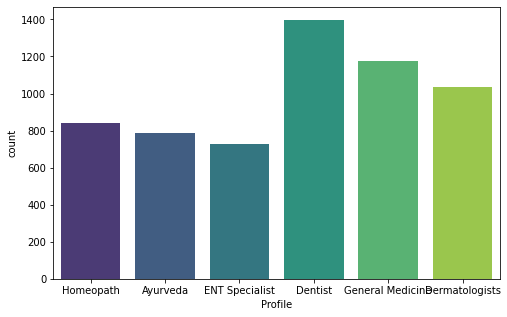

In [305]:
plt.figure(figsize=(8,5))
sns.countplot(df_train['Profile'],palette='viridis',data=df_train)
plt.show()

As we can see that Dentist are more in numbers followed by General Medicines.

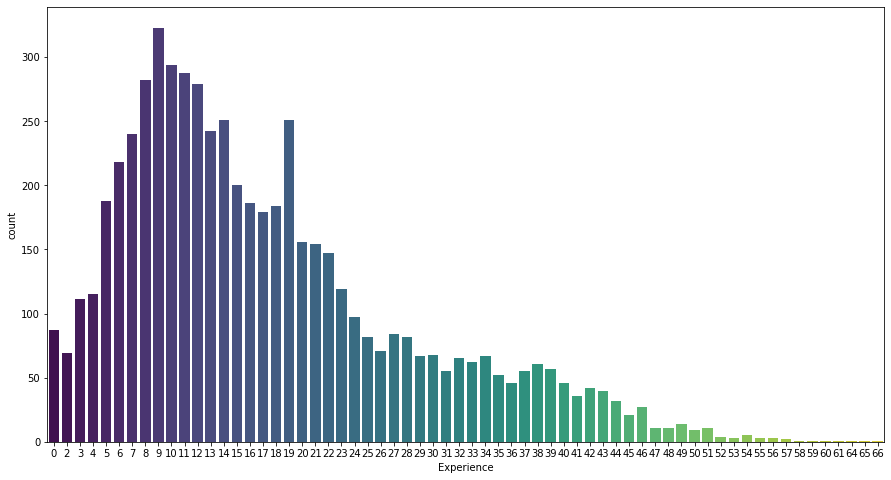

In [306]:
plt.figure(figsize=(15,8))
sns.countplot(df_train['Experience'],palette='viridis',data=df_train)
plt.show()

As we can see that the more number of doctors fall under 5 to 22 years of Experience.

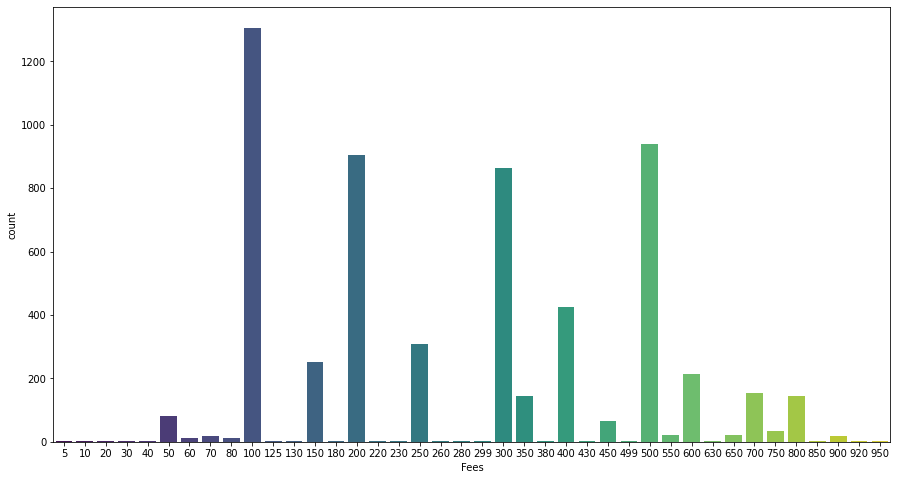

In [307]:
plt.figure(figsize=(15,8))
sns.countplot(df_train['Fees'],palette='viridis',data=df_train)
plt.show()

Here, the details are nicesly spreaded and there is no specific pattern formed.

#### Histogram


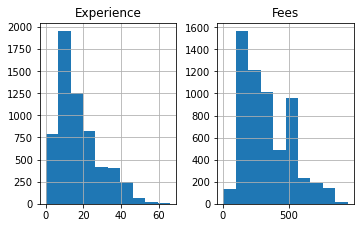

In [308]:
df_train.hist(figsize=(12,12),layout=(3,4),sharex=False);

As shown above, both datasets are not too skewed.

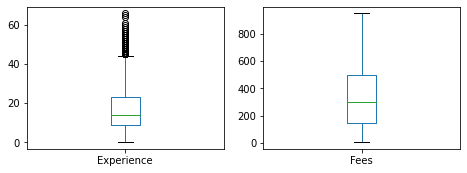

In [309]:
df_train.plot(kind='box',figsize=(12,12),layout=(4,3),sharex=False,subplots=True)
plt.show()

In [310]:
#enc = LabelEncoder()
#df_train = df_train.apply(enc.fit_transform)
#df_train.head()

#### Encoding categorical Variables and scale its features.

In [316]:
x = df_train.drop("Fees",axis=1)
y = df_train['Fees']

In [320]:
# Encoding
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
enc = OrdinalEncoder()
x = pd.DataFrame(enc.fit_transform(x),columns=x.columns)

In [324]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)

In [325]:
#feature scaling
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)

### Implementing SVR modeling

In [327]:
from sklearn.svm import SVR
m = SVR(gamma='scale')
m.fit(scaler.transform(x_train),y_train)

SVR()

In [328]:
def score(y_pred,y):
    y_pred = np.log(y_pred)
    y = np.log(y)
    return 1 - ((np.sum((y_pred-y)**2))/len(y))**1/2

# prediction
y_pred = m.predict(scaler.transform(x_test))
score(y_pred,y_test)

0.7629328919156109

As above, we have received 76.29% accuracy which could be increased during Hyperparameter tuning.

In [331]:
#Define own scorer
from sklearn.metrics import make_scorer
scorer = make_scorer(score,greater_is_better=True)

# Hyperparameter Tunning
parameters = {'C':[0.1,1,10],"kernel":['linear','rbf','poly']}
reg = GridSearchCV(m,param_grid=parameters,scoring=scorer,n_jobs=-1,cv=5)

In [332]:
reg.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring=make_scorer(score))

In [333]:
reg.best_params_

{'C': 10, 'kernel': 'rbf'}

In [335]:
#Final
y_pred_tuned = reg.predict(scaler.transform(x_test))
score(y_pred_tuned,y_test)

0.7933265537286565

Post Tunning we have reach to 79% accuracy

## saving the Model

In [339]:
import pickle
filename = 'Doctor Fee Prediction.pkl'
pickle.dump(reg,open(filename,'wb'))

In [340]:
load_model = pickle.load(open('Doctor Fee Prediction.pkl','rb'))
result = load_model.score(x_test,y_test)
result

0.7370497984506296

While testing we are getting 74 % accuracy